In [2]:
import sys
sys.path.append('../notebooks')
import utils
import os
import numpy as np
import glob
import cv2
import utils
import pylab as pl
import shutil
import matplotlib.cm as cm
from sklearn.cross_validation import train_test_split
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/ipykernel/.*')
%matplotlib inline

In [5]:
# Also load the non-filtered data for evaluation
_d = np.load('../data/data_128_train.npz')
X = _d['X'][:,None,:,:]
Y = _d['Y'][:,None,:,:]

Y_binary = np.sum(np.sum(Y.squeeze(), axis=2), axis=1) > 0
Y_binary = Y_binary.astype(np.float32)
Y_binary = Y_binary[:,None]

# Keras model

In [8]:
os.environ['KERAS_BACKEND'] = 'theano'
# TODO: Use float16 ?
os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN,device=gpu0,floatX=float32'
import keras
from keras.layers import Input, Dense, Dropout, Activation, Flatten, merge, RepeatVector, Permute, Reshape
from keras.layers import Convolution2D, MaxPooling2D, UpSampling2D, MaxoutDense
from keras.layers import LeakyReLU, BatchNormalization
from keras.models import Model
from keras.optimizers import SGD, RMSprop
from keras.utils.layer_utils import print_summary
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
import keras.backend as K

Using Theano backend.
Using gpu device 0: GeForce GTX 960 (CNMeM is disabled, cuDNN 4007)


In [9]:
import theano
print theano.config.device

gpu0


In [10]:
from keras.layers import Layer, InputSpec
import keras.initializations
import keras.backend as K

class Maxout2D(Layer):
    def __init__(self, output_dim, cardinality, init='glorot_uniform', **kwargs):
        super(Maxout2D, self).__init__(**kwargs)
        # the k of the maxout paper
        self.cardinality = cardinality
        # the m of the maxout paper
        self.output_dim = output_dim
        self.init = keras.initializations.get(init)
    
    def build(self, input_shape):
        self.input_dim = input_shape[1]
        self.input_spec = [InputSpec(dtype=K.floatx(),
                                     shape=(None, input_shape[1], input_shape[2], input_shape[3]))]
        self.W = self.init((self.input_dim, self.output_dim, self.cardinality),
                           name='{}_W'.format(self.name))
        self.b = K.zeros((self.output_dim, self.cardinality))
        self.trainable_weights = [self.W, self.b]
              
    def call(self, x, mask=None):
        input_shape = self.input_spec[0].shape
        # flatten the spatial dimensions
        flat_x = K.reshape(x, (-1, input_shape[1], input_shape[2] * input_shape[3]))
        output = K.dot(
            K.permute_dimensions(flat_x, (0, 2, 1)),
            K.permute_dimensions(self.W, (1, 0, 2))
        )
        output += K.reshape(self.b, (1, 1, self.output_dim, self.cardinality))
        output = K.max(output, axis=3)
        output = output.transpose(0, 2, 1)
        output = K.reshape(output, (-1, self.output_dim, input_shape[2], input_shape[3]))
        return output
    
    def get_output_shape_for(self, input_shape):
        return (input_shape[0], self.output_dim, input_shape[2], input_shape[3])
    
    def get_config(self):
        config = {
            'output_dim': self.output_dim,
            'cardinality': self.cardinality
        }
        base_config = super(Maxout2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [12]:
model_dir = '../models/sub48'
model = model_from_json(
    open(os.path.join(model_dir, 'architecture.json')).read(),
            custom_objects={'Maxout2D' : Maxout2D}
)
model.load_weights(os.path.join(model_dir, 'weights.hdf5'))
model.compile(optimizer='adam', loss='binary_crossentropy',
              loss_weights=[1., 1, 1, 1])

print_summary(model.layers)

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
input_img (InputLayer)             (None, 1, 128, 128) 0                                            
____________________________________________________________________________________________________
convolution2d_94 (Convolution2D)   (None, 32, 128, 128)320         input_img[0][0]                  
____________________________________________________________________________________________________
convolution2d_95 (Convolution2D)   (None, 32, 128, 128)9248        convolution2d_94[0][0]           
____________________________________________________________________________________________________
maxout2d_42 (Maxout2D)             (None, 16, 128, 128)1056        convolution2d_95[0][0]           
___________________________________________________________________________________________

In [13]:
from IPython.display import SVG
#from keras.utils.visualize_util import model_to_dot
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

from keras.utils.visualize_util import plot
plot(model, to_file='model.png')

Best map_thresh=0.300000, bin_thresh=0.600000


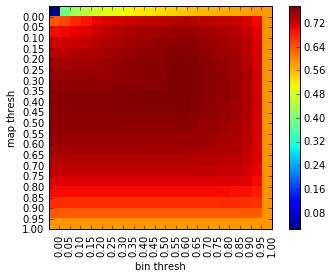

In [14]:
def compute_scores_map(X, Y):
    Y_pred, Y_pred_88, Y_pred_44, Y_pred_binary = model.predict(X)
    
    map_threshs = np.linspace(0, 1, num=21)
    bin_threshs = np.linspace(0, 1, num=21)
    
    scores = np.zeros((len(map_threshs), len(bin_threshs)))
    for i in range(len(map_threshs)):
        for j in range(len(bin_threshs)):
            _Y_pred = Y_pred > map_threshs[i]
            
            for k in range(_Y_pred.shape[0]):
                # Clear prediction where we detect to little pixels
                if np.sum(_Y_pred[k]) < 150 or Y_pred_binary[k] < bin_threshs[j]:
                    _Y_pred[k,:] = 0
            
            scores[i, j] = utils.average_dice_coefficient(_Y_pred, Y)
    
    pl.imshow(scores, interpolation='nearest')
    pl.yticks(np.arange(len(map_threshs)) + 0.5, ['%.2f' % v for v in map_threshs])
    pl.xticks(np.arange(len(bin_threshs)) + 0.5, ['%.2f' % v for v in bin_threshs], rotation=90)
    pl.ylabel('map thresh')
    pl.xlabel('bin thresh')
    pl.colorbar()
    
    best_i, best_j = np.unravel_index(np.argmax(scores.ravel()), scores.shape)
    best_map_thresh = map_threshs[best_i]
    best_bin_thresh = bin_threshs[best_j]
    return best_map_thresh, best_bin_thresh

map_thresh, bin_thresh = compute_scores_map(X, Y)
print 'Best map_thresh=%f, bin_thresh=%f' % (map_thresh, bin_thresh)

In [24]:
map_thresh = 0.2
bin_thresh = 0.0

In [25]:
def predict(X, map_thresh, bin_thresh):
    Y_pred, Y_pred_88, Y_pred_44, Y_pred_binary = model.predict(X)
    Y_pred_binary = Y_pred_binary.squeeze()
    Y_pred_proba = Y_pred
    Y_pred = Y_pred > map_thresh
    for i in range(Y_pred.shape[0]):
        if np.sum(Y_pred[i]) < 150 or Y_pred_binary[i] < bin_thresh:
            Y_pred[i,:] = 0
        pass
    return Y_pred, Y_pred_proba, Y_pred_binary

Y_full_pred, Y_full_pred_proba, Y_full_pred_binary = predict(X, map_thresh, bin_thresh)

print "full set score : ", utils.dice_coefficient(Y_full_pred, Y_full)
print "avg full set score : ", utils.average_dice_coefficient(Y_full_pred, Y_full)

full set score :  0.660586003322
avg full set score :  0.769948587079


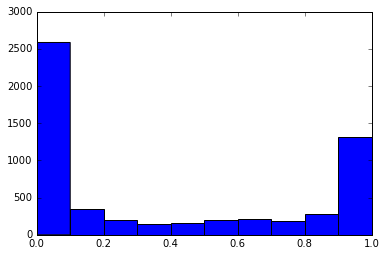

In [26]:
_ = pl.hist(Y_full_pred_binary)

In [27]:
# Find the images with lowest scores
dice_scores = []
for i in range(Y_full_pred.shape[0]):
    dice_scores.append(utils.dice_coefficient(Y_full_pred[i], Y[i]))
dice_scores = np.array(dice_scores)
lowest = np.argsort(dice_scores)

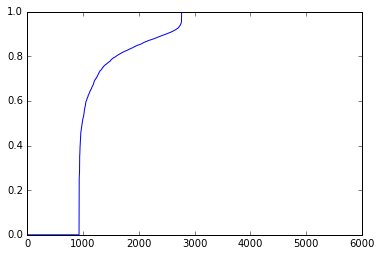

In [28]:
pl.plot(dice_scores[lowest])
#pl.plot(Y_pred_binary[lowest], c='r')

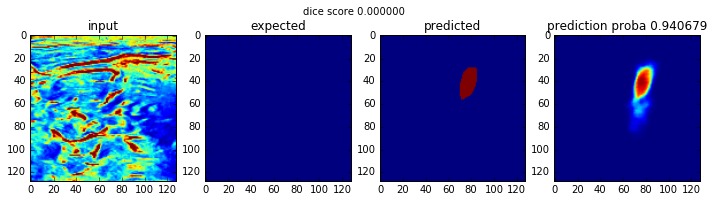

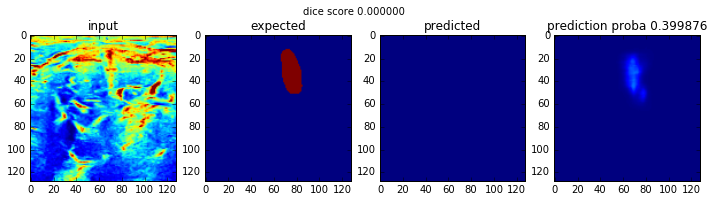

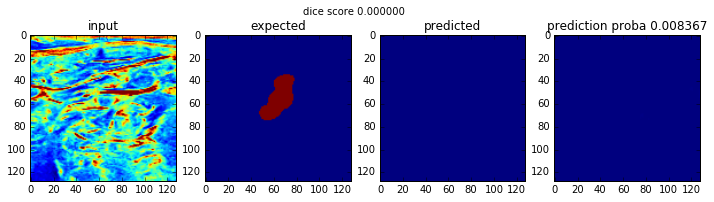

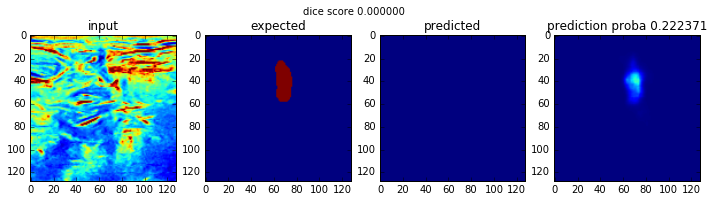

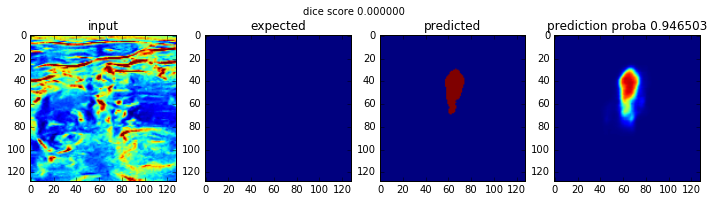

In [30]:
#i = 50
#i = 47

#for i in lowest[380:385]:
for i in lowest[40:45]:
    pl.figure(figsize=(12, 3))
    pl.suptitle('dice score %f' % utils.dice_coefficient(Y_full_pred[i], Y[i]))
    pl.subplot(141)
    pl.title('input')
    pl.imshow(X[i].squeeze())
    pl.subplot(142)
    pl.title('expected')
    pl.imshow(Y[i].squeeze())
    pl.subplot(143)
    pl.title('predicted')
    pl.imshow(Y_full_pred[i].squeeze(), vmin=0, vmax=1)
    pl.subplot(144)
    #print np.sum(Y_pred[i].squeeze())
    pl.title('prediction proba %f' % Y_full_pred_binary[i])
    pl.imshow(Y_full_pred_proba[i].squeeze(), vmin=0, vmax=1)

# Run the model on kaggle'7 test set

In [31]:
_d = np.load('../data/data_128_test.npz')
X_submit = _d['X']

Y_pred, Y_pred_88, Y_pred_44, Y_pred_binary = model.predict(X_submit[:,None,:,:])
Y_pred_binary = Y_pred_binary.squeeze()
Y_pred_proba = Y_pred

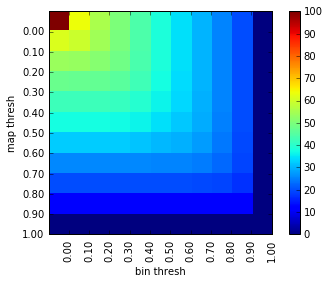

In [32]:
def Y_to_binary(Y_pred, Y_pred_binary, map_thresh, bin_thresh):
    Y_pred = Y_pred > map_thresh
    for i in range(Y_pred.shape[0]):
        if np.sum(Y_pred[i]) < 150 or Y_pred_binary[i] < bin_thresh:
            Y_pred[i,:] = 0
        pass
    return Y_pred, Y_pred_proba, Y_pred_binary

map_threshs = np.linspace(0, 1, num=11)
bin_threshs = np.linspace(0, 1, num=11)

masks_per = np.zeros((len(map_threshs), len(bin_threshs)))
for i in range(len(map_threshs)):
    for j in range(len(bin_threshs)):
        m_t = map_threshs[i]
        b_t = bin_threshs[j]
        _pred, _pred_proba, _pred_binary = Y_to_binary(Y_pred, Y_pred_binary, m_t, b_t)
        # Turn labels into boolean present/missing
        _pred_binary = np.sum(np.sum(np.sum(_pred, axis=2), axis=1), axis=1) > 0
        _pred_binary = _pred_binary.astype(np.float32)
        per_mask = (100 * np.count_nonzero(_pred_binary) / float(len(_pred_binary)))

        masks_per[i, j] = per_mask

pl.imshow(masks_per, interpolation='nearest')
pl.yticks(np.arange(len(map_threshs)) + 0.5, ['%.2f' % v for v in map_threshs])
pl.xticks(np.arange(len(bin_threshs)) + 0.5, ['%.2f' % v for v in bin_threshs], rotation=90)
pl.ylabel('map thresh')
pl.xlabel('bin thresh')
pl.colorbar()

In [36]:
map_thresh = 0.3
bin_thresh = 0.3

In [37]:
if True:
    import cv2
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(50,50))
    
    _d = np.load('../data/data_128_test.npz')
    X_submit = _d['X']
    test_fnames = _d['test_fnames']
    # bin_thresh
    Y_pred, Y_pred_proba, Y_pred_binary = predict(X_submit[:,None,:,:],
                                                  map_thresh, bin_thresh)
    
    OUTDIR='../../preds'
    if os.path.exists(OUTDIR):
        shutil.rmtree(OUTDIR)
    utils.mkdir_p(OUTDIR)

    for i in range(Y_pred.shape[0]):
        imre = (Y_pred[i].squeeze() * 255).astype(np.uint8)
        imre = cv2.morphologyEx(imre, cv2.MORPH_CLOSE, kernel)
        imre = cv2.resize(imre, (580, 420))
        
        basename = os.path.splitext(test_fnames[i])[0]
        cv2.imwrite(os.path.join(OUTDIR, basename + '.png'), imre)
        
        if i % 10 == 0:
            print '\r%d / %d' % (i, len(test_fnames)),
            sys.stdout.flush()

5500 / 5508


In [38]:
# Turn labels into boolean present/missing
pred_binary = np.sum(np.sum(np.sum(Y_pred, axis=2), axis=1), axis=1) > 0
pred_binary = pred_binary.astype(np.float32)
print "%.2f%% with masks" % (100 * np.count_nonzero(pred_binary) / float(len(pred_binary)))

45.84% with masks


## Stats on predicted masks

(0, 1200)

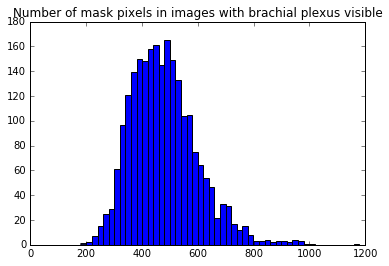

In [39]:
# on Y_full
nbp_pixels = np.sum(np.sum(np.sum(Y_full, axis=1), axis=1), axis=1)
bpvisible = nbp_pixels > 0

pl.figure()
pl.title('Number of mask pixels in images with brachial plexus visible')
_ = pl.hist(nbp_pixels[bpvisible], bins=50)
pl.xlim((0, 1200))

(0, 1200)

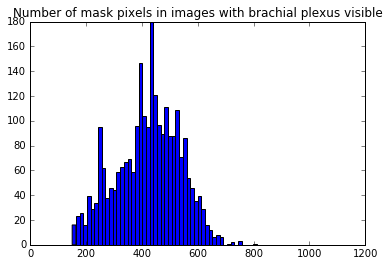

In [40]:
# on pred
nbp_pixels = np.sum(np.sum(np.sum(Y_pred, axis=1), axis=1), axis=1)
bpvisible = nbp_pixels > 0

pl.figure()
pl.title('Number of mask pixels in images with brachial plexus visible')
_ = pl.hist(nbp_pixels[bpvisible], bins=50)
pl.xlim((0, 1200))